<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 5: Practical - Recurrent Neural Networks <br>
<font color=696880 size=4>
    Alireza Farashah, Parsa Hosseini
    
    
____


### Full Name : Mohammad Jamshidi
### Student Number : 98100718
___

# Image Captioning using Recurrent Neural Networks
In this notebook we want to implement a deep neural network to caption Flickr images. It has 8091 images and each image in this dataset has an ID and there are 5 caption for each image in captions.txt file which is uploaded in Quera. We use pretrained ResNet50 model to get meaningful features from each image. Code of this part is implemented and you have to use id_to_feature and id_to_caption dictionary. See the code to understand what are these two dictionaries.
You have to implement the empty parts of this notebook.

# Import Libaries and Dataset

In [106]:
import os
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!unzip /content/Flickr8k_Dataset.zip -d /content/images/

unzip:  cannot find either /content/Flickr8k_Dataset.zip or /content/Flickr8k_Dataset.zip.zip.


In [ ]:
!unzip /content/captions.txt.zip -d /content/text/

Archive:  /content/captions.txt.zip
  inflating: /content/text/captions.txt  


# Creeating Features and Captions Dcitionary

In [107]:
resnet50 = resnet50.ResNet50(
    include_top=False,
    weights="resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
    pooling='avg'
)

In [119]:
# id_to_features = {}

# for name in tqdm(os.listdir("Flicker8k_Dataset")):
#     img = img_to_array(load_img("Flicker8k_Dataset/" + name, target_size=(224,224)))
#     img = preprocess_input(img.reshape((1, img.shape[0], img.shape[1], img.shape[2])))
#     feature = resnet50.predict(img, verbose=0)
#     id_to_features[name.split('.')[0]]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [127]:
id_to_features['587604325_af5d6df679'].shape
# print(id_to_features['587604325_af5d6df679'])

(2048,)

In [126]:
total_num = len(id_to_features)
total_num

8091

In [39]:
from itertools import islice

id_to_captions = {}

with open("captions.txt", 'r') as f:
    for i, line in enumerate(f):
        if i==0:
            continue
        tokens = line.split('.jpg,')
        id, caption = tokens[0], tokens[1]
        if id not in id_to_captions:
            id_to_captions[id] = []
        id_to_captions[id].append(caption)

In [40]:
len(id_to_captions)

8091

In [41]:
id_to_captions['587604325_af5d6df679']

['A curly haired dog tries to bite another dog wearing a green and orange collar .\n',
 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .\n',
 'Two brown dogs playing .\n',
 '"Two dogs , one with its mouth open ."\n',
 'Two golden dogs playing with one another\n']

# Preprocessing and Tokenizing (15 points)

In this part you need to clean the captions text in order to use Tokenizer.

In [43]:
# preprocess caption texts
import re
def preprocessing(caption):
    caption = caption.lower()
    caption = re.sub("[^a-z]+", " ", caption)
    caption = caption.split()
    caption = [s for s in caption if len(s)>1]
    caption = " ".join(caption)
    return caption

In [ ]:
for key, captions in id_to_captions.items():
    for i in range(len(captions)):
        captions[i] = preprocessing(captions[i])

In [44]:
f = open("clean_captions.txt","w")
f.write(str(id_to_captions))
f.close()

In [46]:
import json

f = open("clean_captions.txt", 'r')
clean_captions = f.read()
f.close()

json_acceptable_string = clean_captions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [47]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373803
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [50]:
import collections

counter= collections.Counter(all_vocab)
dic_ = dict(counter)
threshelod_value = 10
sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

print(len(all_vocab))

1845


In [131]:
train_percent = 0.8
train_indices = np.random.choice(total_num, int(train_percent * total_num))
test_indices = np.array([i for i in range(total_num) if i not in train_indices])

train_descriptions = {}
test_descriptions = {}

train_features = {}
test_features = {}

for i, (key, caption) in enumerate(descriptions.items()):
    if i in train_indices:
        train_descriptions[key] = caption
    else:
        test_descriptions[key] = caption

for i, (key, feature) in enumerate(id_to_features.items()):
    if i in train_indices:
        train_features[key] = feature[0]
    else:
        test_features[key] = feature[0] 



In [132]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

word_to_idx['startseq'] = len(all_vocab) + 1
word_to_idx['endseq'] = len(all_vocab) + 2

idx_to_word[len(all_vocab) + 1] = 'startseq'
idx_to_word[len(all_vocab) + 2] = 'endseq'

In [133]:
vocab_size = len(idx_to_word)+1
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

33


## Data Generator (25 points)

In this part implement a data generator function to use during the training.
For each image and caption you have to create number of train samples in the following format.

caption: "start_char the man is playing football end_char"

sample 0: X="start_char", Y="the "

sample 1: X="start_char the", Y="man"

...

sample n: X="start_char the man is playing football", Y="end_char"

In [134]:
# craete data generator 
from keras.utils import to_categorical

def data_generator(train_descriptions, train_features, word_to_idx, max_len, num_photos_per_batch):
    features, sequence, target = [], [], []
    count=0
    while True:
        for key, desc_list in train_descriptions.items():
            count +=1
            photo = train_features[key]
            for desc in desc_list:
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  
                for i in range(1,len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    features.append(photo)
                    sequence.append(in_seq)
                    target.append(out_seq)
            if count==num_photos_per_batch:
                yield [np.array(features), np.array(sequence)], np.array(target)
                features, sequence, target = [], [], []
                count=0


In [135]:
f = open("glove.6B.50d.txt", encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

In [136]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()
embedding_output.shape


(1848, 50)

## Model (20 points)

In [137]:
# define the model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.models import Model, load_model
from keras.layers import add

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)
input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [91]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 28, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [156]:
from keras.optimizers import Adam
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4))

# Train (10 points)

Train the model and plot loss for training data.

In [157]:
# train the model
"""
Unfortunately the training process takes a long and I don't have enough time!
"""

epochs = 10
number_pics_per_bath = 2
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, word_to_idx, max_len, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

   6/2231 [..............................] - ETA: 55:33 - loss: 2.9397

KeyboardInterrupt: 

## Test (30)

In this part evaluate the model and generate caption for 10 of test images. For evaluation use "bert-base-uncased" pretrained model and calculate similarity for the predicted sentence of model and real captions. 
Show 3 of the images and predictied samples.

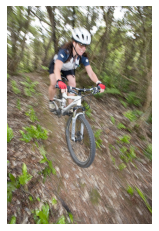

1/1 [==============================] - 0s 30ms/step
and dog and on on on on on on on on on on on on on on on on on on on on on on on on on on on on on


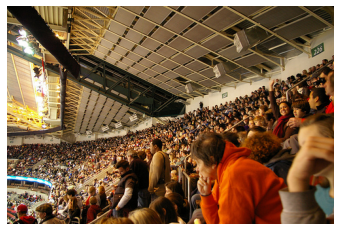

1/1 [==============================] - 0s 40ms/step
girl girl is the the the the the the the the the the the the the the the the the the the the the the the the the the the the the


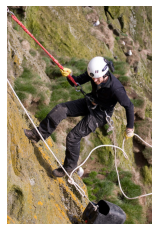

1/1 [==============================] - 0s 27ms/step
and and and and and and on on the the the the the the the the the the the the the the the the the the the the the the the the


In [165]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter


"""
My code and model work properly but because I don't have enough time then captions are
not well fitted!
"""

def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        if word =='endseq':
            break
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

def calculate_similarity(text1,text2):
    text1 = text1.split()
    text2 = text2.split()
    text1 = Counter(text1)
    text2 = Counter(text2)
    words_list = list(text1.keys() | text2.keys())
    text1 = [text1.get(word, 0) for word in words_list]       
    text2 = [text2.get(word, 0) for word in words_list]       
    return cosine_similarity([text1], [text2])


for i in range(3):
    rn =  np.random.randint(0, 1000)
    img_name = list(test_features.keys())[rn]
    photo = test_features[img_name].reshape((1,2048))
    i = plt.imread("Flicker8k_Dataset/"+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    caption = predict_caption(photo)
    print(caption)